In [2]:
import sys
sys.path.append("..")
import anndata as ad
import pandas as pd
from viewer import *

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import tqdm

def find_representative_cells(df, group_column, feature_columns, method='random', n=1):
    # Ensure feature_columns is a list
    if isinstance(feature_columns, str):
        feature_columns = [feature_columns]

    # Initialize a list to hold the selected rows
    selected_rows = []

    # Group by the specified column
    groups = df.groupby(group_column)

    for name, group in tqdm.tqdm(groups):
        if name == "unassigned":
            print(name, "not a valid cluster")
            continue
        # Apply the selection method
        if method == 'random':
            # Randomly select n rows from the group
            selected_rows.append(group.sample(n=n))

        elif method == 'geomean':
            # Calculate the geometric mean of the feature columns for each group
            geomean = group[feature_columns].apply(lambda x: np.prod(x)**(1/len(x)), axis=0)
            # Find the row closest to the geometric mean
            closest = (group[feature_columns] - geomean).apply(np.linalg.norm, axis=1).idxmin()
            selected_rows.append(group.loc[[closest]])

        elif method == 'kmeans':
            if group.shape[0] > 60:
                n_cells_in_each_cluster_unif = 30
            else:
                n_cells_in_each_cluster_unif = int(group.shape[0] / 5)

            n_clusts = int(group.shape[0] / n_cells_in_each_cluster_unif)
            # Apply k-means clustering on the feature columns to find the most representative row
            kmeans = KMeans(n_clusters=n_clusts, random_state=0, n_init=10).fit(group[feature_columns])
            centroid = kmeans.cluster_centers_[0]
            closest = (group[feature_columns] - centroid).apply(np.linalg.norm, axis=1).idxmin()
            selected_rows.append(group.loc[[closest]])

        elif method == 'kmedoid':
            # Check if group is smaller than n
            if len(group) < n:
                raise ValueError(f"Group {name} has fewer rows than the number of requested representatives.")

            # Initialize and fit the KMedoids
            kmedoids = KMedoids(n_clusters=n, random_state=0).fit(group[feature_columns].values)
            
            # Get the indices of the medoids
            medoids_indices = kmedoids.medoid_indices_

            # Select rows corresponding to medoids
            for index in medoids_indices:
                selected_rows.append(group.iloc[[index]])

        else:
            raise ValueError("Unknown method: choose 'random', 'geomean', or 'kmeans'")

    # Concatenate all selected rows into a new DataFrame
    result_df = pd.concat(selected_rows, axis=0).reset_index(drop=True)
    sorted_df = result_df.sort_values(by=['Metadata_cmpdName'], ascending=[True])
    return sorted_df


In [5]:
def show_representatives_v2(df, box_size, grouping, n_cells):
    df['Metadata_Site'] = df['Metadata_Site'].astype(str)
    df['Metadata_Site'] = df['Metadata_Site'].str.extract('(\d+)').astype(int)

    views = []
    # Define top row as labels
    # Assuming you want to group by 'Metadata_Plate' and 'Metadata_Well'
    site_row = []
    for i in range(0, n_cells + 2):
        if i == 0:
            site_row.append(View(hover='(padding at top left)'))
        elif i == (n_cells + 1):
            site_row.append(View(hover='(padding at top right)'))
        else:
            site_row.append(View(overlay=f'Cell {i}', overlay_style=style7 + ":white-space: pre", overlay_dir='S'))
    views.append(site_row)
    groups = df[grouping].unique()
    y = 1
    for g in groups:
        row_views = []
        print(g)
        group = df[df[grouping] == g]
        x = 1
        for index, row in group.iterrows():
                plate = row["Metadata_Plate"]
                well = row["Metadata_Well"]
                site = row["Metadata_Site"]
                center_x = row["Nuclei_Location_Center_X"]
                center_y = row["Nuclei_Location_Center_Y"]
                row_views.append(View(
                    barcode=plate, well=well, site=site,
                    #clip=ClipBox(center_x - box_size // 2, center_y - box_size // 2, box_size, box_size),
                    clip = ClipSquare(center_x, center_y, box_size),
                    #x = x,
                    #y = y
                ))
                x += 1
        y += 1
        row_views.insert(0, View(overlay=g, overlay_style=style7 + ";text-align:right", overlay_dir='E'))
        views.append(row_views)
    views.append([View(hover='(padding at bottom left)')])
    return views

def table(grid):
    res = []
    for y, row in enumerate(grid):
        for x, cell in enumerate(row):
            assert isinstance(cell, View), f'Execpted View, got: {cell} ({y=}, {x=})'
            res += [replace(cell, x=x, y=y)]
    #return res
    return Viewer(res)

In [19]:
def find_representative_views(file_path, grouping_col, n_rep, method = "kmedoid", image_size = 250, compounds_filter = None):
    print("Importing data")
    location_df = ad.read_h5ad(file_path)
    if compounds_filter is not None:
        location_df = location_df[location_df.obs['Metadata_cmpdName'].isin(compounds_filter)]
    
    location_pd = anndata_to_pandas(location_df)

    #if compounds_filter is not None:
    #    location_pd = location_pd[location_pd['Metadata_cmpdName'].isin(compounds_filter)]

    # Reset the index to avoid issues with previous groupings
    location_pd = location_pd.reset_index(drop=True)
    feature_cols = [feat for feat in location_pd.columns if "Feature" in feat]
    print("Finding representatives", location_pd.shape)
    representatives = find_representative_cells(location_pd, grouping_col, feature_cols, method=method, n=n_rep)
    representative_sort = representatives.sort_values(by=[grouping_col])
    print(representative_sort)
    print("Generating views")
    views = show_representatives_v2(representative_sort, image_size, grouping = grouping_col, n_cells = n_rep)
    return views, representative_sort

## Find representative cells

In [20]:
views, representative_df = find_representative_views("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/celldeath_DINO_sampled.h5ad", "Metadata_cmpdName", 1, image_size= 150, compounds_filter= ["NIGERICIN", "FK 866", "HS-173", "FIN 56", "CRIZOTINIB", "EVEROLIMUS"])

Importing data


/tmp/ipykernel_1846030/3847931094.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(group_column)


Finding representatives (80495, 452)


100%|██████████| 6/6 [00:56<00:00,  9.43s/it]

    index    name_0 Metadata_Well Metadata_Site Metadata_cmpdName  \
0  139579  120750-1           O13            s5        CRIZOTINIB   
1  115082   36845-1           K20            s7        EVEROLIMUS   
2  113346   31885-1           J22            s4            FIN 56   
3  164978  179845-1           L22            s7            FK 866   
4  158603  167133-1           J07            s1            HS-173   
5     403    1097-0           B09            s8         NIGERICIN   

                      moa Metadata_cmpdConc                       epoch  \
0  immunogenic cell death               3.0  features_0200_part2_nomask   
1       autophagy inducer               5.0  features_0200_part2_nomask   
2     ferroptosis inducer               3.0  features_0200_part2_nomask   
3               apoptosis               0.1  features_0200_part2_nomask   
4     necroptosis inducer               5.0  features_0200_part2_nomask   
5      pyroptosis inducer               0.1  features_0200_part1_n

In [16]:
table(views)

<iframe src="https://im.devserver.pharmb.io/v0.1.html#barcode=&well=&x=0&y=0&hover=%28padding+at+top+left%29&barcode=&well=&x=1&y=0&overlay=Cell+1&overlay_dir=S&overlay_style=background%3A+black%3B+padding%3A+0+10px%3Awhite-space%3A+pre&barcode=&well=&x=2&y=0&hover=%28padding+at+top+right%29&barcode=&well=&x=0&y=1&overlay=CRIZOTINIB&overlay_dir=E&overlay_style=background%3A+black%3B+padding%3A+0+10px%3Btext-align%3Aright&barcode=PB000051&well=O13&site=5&clip=1013%2C198%2C150&x=1&y=1&barcode=&well=&x=0&y=2&overlay=EVEROLIMUS&overlay_dir=E&overlay_style=background%3A+black%3B+padding%3A+0+10px%3Btext-align%3Aright&barcode=PB000050&well=K20&site=7&clip=2650%2C1879%2C150&x=1&y=2&barcode=&well=&x=0&y=3&overlay=FIN+56&overlay_dir=E&overlay_style=background%3A+black%3B+padding%3A+0+10px%3Btext-align%3Aright&barcode=PB000050&well=J22&site=4&clip=1380%2C1993%2C150&x=1&y=3&barcode=&well=&x=0&y=4&overlay=FK+866&overlay_dir=E&overlay_style=background%3A+black%3B+padding%3A+0+10px%3Btext-align%3Ari

Viewer(views=[View(barcode='', well='', site=None, clip=None, x=0, y=0, hover='(padding at top left)', overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=1, y=0, hover=None, overlay='Cell 1', overlay_dir='S', overlay_style='background: black; padding: 0 10px:white-space: pre'), View(barcode='', well='', site=None, clip=None, x=2, y=0, hover='(padding at top right)', overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=0, y=1, hover=None, overlay='CRIZOTINIB', overlay_dir='E', overlay_style='background: black; padding: 0 10px;text-align:right'), View(barcode='PB000051', well='O13', site=5, clip=ClipSquare(x='1013', y='198', side=150), x=1, y=1, hover=None, overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=0, y=2, hover=None, overlay='EVEROLIMUS', overlay_dir='E', overlay_style='background: black; padding: 0 10px;text-align:right'), View(barcode='PB000050', well='K20', site=7, clip=ClipSquare(x='2650', y='1879', side=150), x=1, y=2, hover=None, overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=0, y=3, hover=None, overlay='FIN 56', overlay_dir='E', overlay_style='background: black; padding: 0 10px;text-align:right'), View(barcode='PB000050', well='J22', site=4, clip=ClipSquare(x='1380', y='1993', side=150), x=1, y=3, hover=None, overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=0, y=4, hover=None, overlay='FK 866', overlay_dir='E', overlay_style='background: black; padding: 0 10px;text-align:right'), View(barcode='PB000052', well='L22', site=7, clip=ClipSquare(x='2663', y='551', side=150), x=1, y=4, hover=None, overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=0, y=5, hover=None, overlay='HS-173', overlay_dir='E', overlay_style='background: black; padding: 0 10px;text-align:right'), View(barcode='PB000052', well='J07', site=1, clip=ClipSquare(x='1703', y='2379', side=150), x=1, y=5, hover=None, overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=0, y=6, hover=None, overlay='NIGERICIN', overlay_dir='E', overlay_style='background: black; padding: 0 10px;text-align:right'), View(barcode='PB000046', well='B09', site=8, clip=ClipSquare(x='2536', y='2017', side=150), x=1, y=6, hover=None, overlay=None, overlay_dir=None, overlay_style=None), View(barcode='', well='', site=None, clip=None, x=0, y=7, hover='(padding at bottom left)', overlay=None, overlay_dir=None, overlay_style=None)], width='100%', height='800px')

In [54]:
metadata_celldeath = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/crops_unmasked/metadata_beactica_finetune_DINO_unmasked.csv")

In [63]:
def inner_join_polars(df1, df2):
    """
    Performs an inner join between two polars DataFrames, ensuring that data types match.
    
    Parameters:
    - df1: First DataFrame (left).
    - df2: Second DataFrame (right).
    
    Returns:
    - joined_df: Result of the inner join.
    """
    # Define the columns to join on
    left_columns = ["Metadata_Site", "Metadata_Well", "Metadata_Plate", "Nuclei_Location_Center_X", "Nuclei_Location_Center_Y"]
    right_columns = ["Site", "Well", "plate", "X_coord", "Y_coord"]
    
    # Ensure that the dtypes match between df1 and df2
    for left_col, right_col in zip(left_columns, right_columns):
        if df1[left_col].dtype != df2[right_col].dtype:
            # Handle categorical types separately
            if df1[left_col].dtype == pl.Categorical:
                # Convert the column in df2 to string first, then to categorical
                df2 = df2.with_columns(df2[right_col].cast(str).cast(pl.Categorical))
            elif df2[right_col].dtype == pl.Categorical:
                # Convert the column in df1 to string first, then to categorical
                df1 = df1.with_columns(df1[left_col].cast(str).cast(pl.Categorical))
            else:
                # For other types, cast directly
                df2 = df2.with_columns(df2[right_col].cast(df1[left_col].dtype))
    
    # Perform the inner join using different column names
    joined_df = df1.join(
        df2,
        left_on=left_columns,
        right_on=right_columns,
        how='inner'
    )
    
    return joined_df

In [64]:
joined_df = inner_join_polars(pl.DataFrame(representative_df), metadata_celldeath)
# print(joined_df.head())

/tmp/ipykernel_1846030/2684828276.py:31: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  joined_df = df1.join(


In [67]:
joined_df.write_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/representative_cells_celldeath.csv")

## Show grid of attentions

In [99]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def load_image(image_path):
    """ Load an image from the given path. """
    if os.path.isfile(image_path):
        return Image.open(image_path)
    else:
        print(f"Image not found: {image_path}")
        return None

def extract_cell_id(image_path):
    """
    Extract the cell ID from the image path and format it correctly.
    
    Example:
    - Input:  "PB000051/O13_s5_object5.tiff"
    - Output: "PB000051_O13_s5_object5"
    """
    # Remove the file extension
    cell_id = os.path.splitext(image_path)[0]
    # Replace '/' with '_'
    cell_id = cell_id.replace('/', '_')
    return cell_id

def create_image_grid(base_dir, cell_id):
    """
    Creates a grid with channels and attention maps.
    
    Parameters:
    - base_dir (str): The base directory where images are stored.
    - cell_id (str): The unique identifier for the set of images.
    
    The layout:
    - Top row: 5 channels (DNA, RNA, AGP, Mito, ER) + 1 cell location.
    - Bottom row: 6 attention heads (from attn-head0 to attn-head5).
    """
    
    # Define paths for channels
    channels = [
        f"{base_dir}/{cell_id}_channel_1.png",  # DNA
        f"{base_dir}/{cell_id}_channel_2.png",  # RNA
        f"{base_dir}/{cell_id}_channel_3.png",  # AGP
        f"{base_dir}/{cell_id}_channel_4.png",  # Mito
        f"{base_dir}/{cell_id}_channel_5.png"   # ER
    ]
    
    # Define corresponding channel names
    channel_names = ["DNA", "RNA", "AGP", "Mito", "ER"]
    
    # Define paths for attention heads (from attn-head0 to attn-head5)
    attention_heads = [
        f"{base_dir}/attn-head0_{cell_id}_.png",
        f"{base_dir}/attn-head1_{cell_id}_.png",
        f"{base_dir}/attn-head2_{cell_id}_.png",
        f"{base_dir}/attn-head3_{cell_id}_.png",
        f"{base_dir}/attn-head4_{cell_id}_.png",
        f"{base_dir}/attn-head5_{cell_id}_.png"
    ]
    
    # Create a figure with a grid (2 rows, 6 columns)
    fig, axes = plt.subplots(2, 6, figsize=(18, 6), gridspec_kw={'wspace': 0.001, 'hspace': 0.2})
    
    # Plot channels on the first row
    for i, (channel_path, channel_name) in enumerate(zip(channels, channel_names)):
        img = load_image(channel_path)
        if img:
            axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(channel_name, fontweight='bold')
    
    # Set the last cell in the first row with "Cell Location"
    axes[0, 5].axis('off')
    axes[0, 5].set_title("Cell Location", fontweight='bold')
    
    # Plot attention heads on the second row
    for i, attn_path in enumerate(attention_heads):
        img = load_image(attn_path)
        if img:
            axes[1, i].imshow(img, cmap='hot')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Attention Head {i}", fontweight='bold')

    # Adjust layout and show the plot

    plt.tight_layout()
    
    output_path = os.path.join(base_dir, "attention_grid.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved grid to {output_path}")

    plt.show()


# Example usage:
# Adjust these variables based on your folder structure
base_dir = "/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/output/attention_maps/"

PB000046/B09_s8_object319.tiff


/tmp/ipykernel_1846030/1967877260.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved grid to /home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/output/attention_maps/PB000046/B09_s8_object319.tiff/attention_grid.png


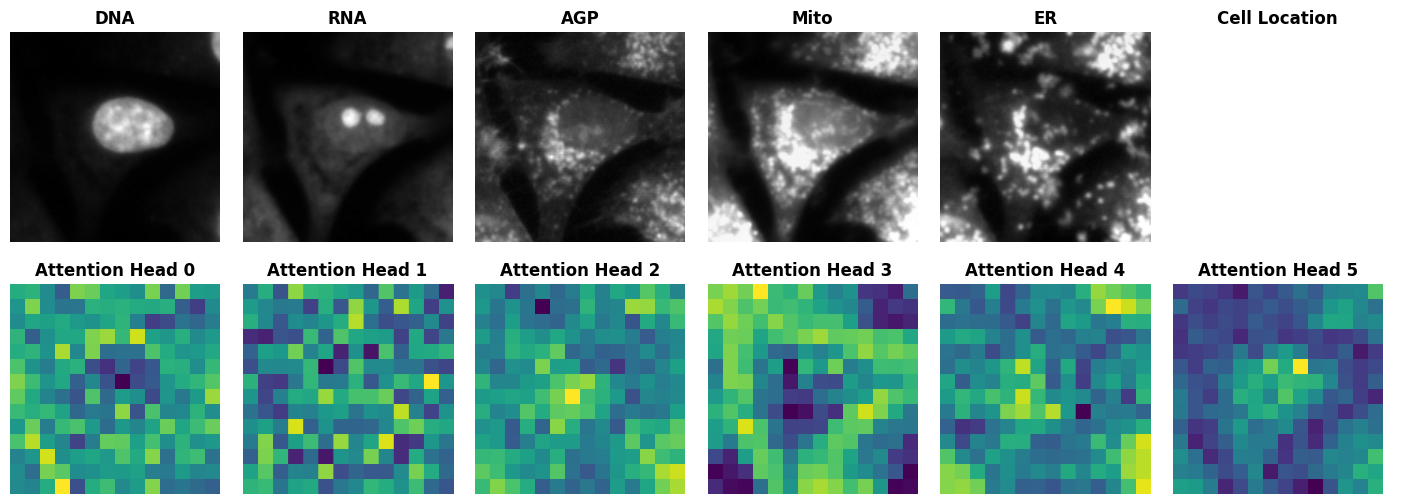

PB000050/J22_s4_object415.tiff
Saved grid to /home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/output/attention_maps/PB000050/J22_s4_object415.tiff/attention_grid.png


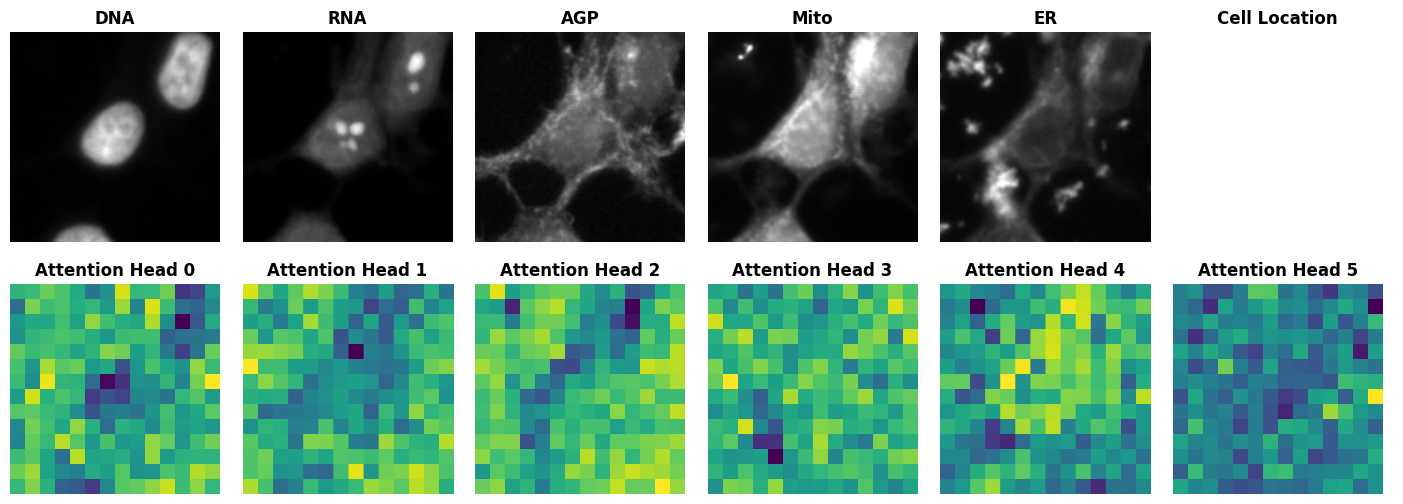

PB000050/K20_s7_object455.tiff
Saved grid to /home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/output/attention_maps/PB000050/K20_s7_object455.tiff/attention_grid.png


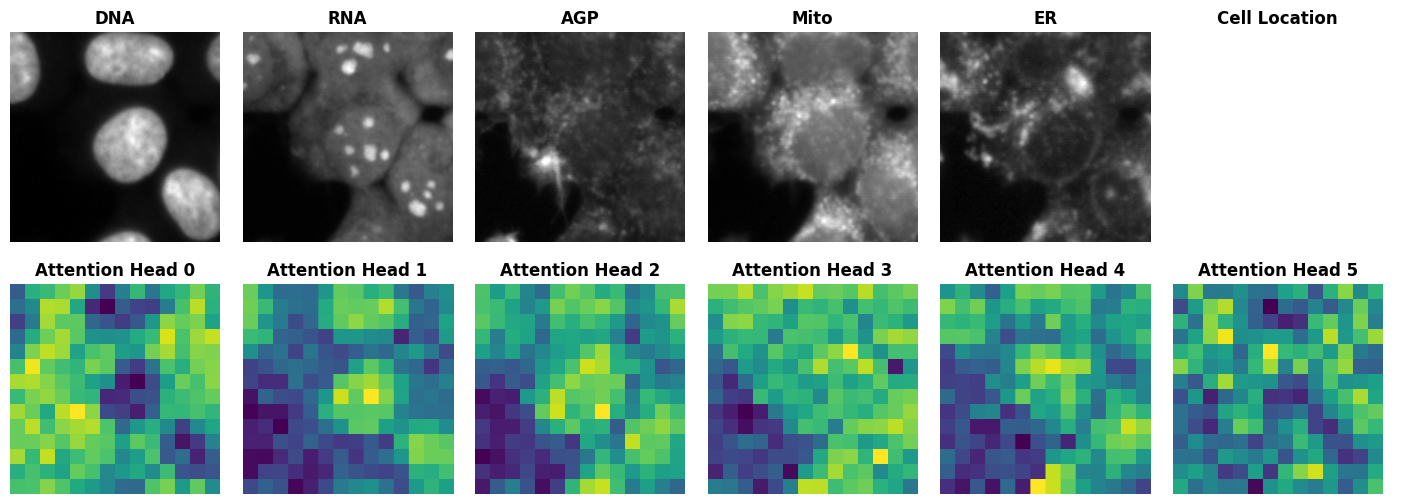

PB000051/O13_s5_object5.tiff
Saved grid to /home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/output/attention_maps/PB000051/O13_s5_object5.tiff/attention_grid.png


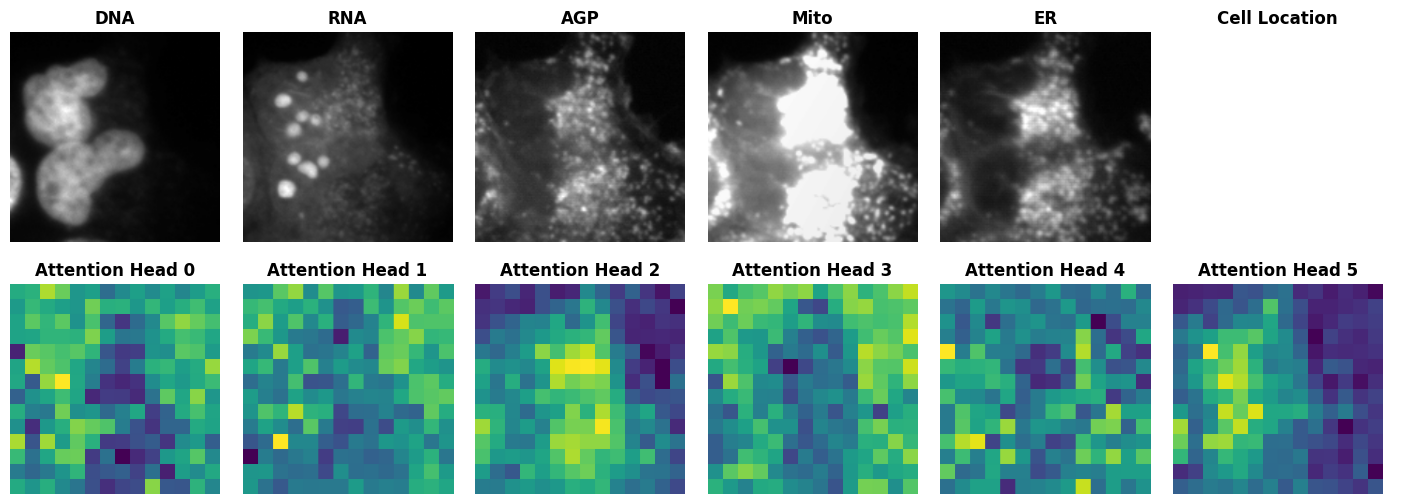

PB000052/J07_s1_object130.tiff
Saved grid to /home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/output/attention_maps/PB000052/J07_s1_object130.tiff/attention_grid.png


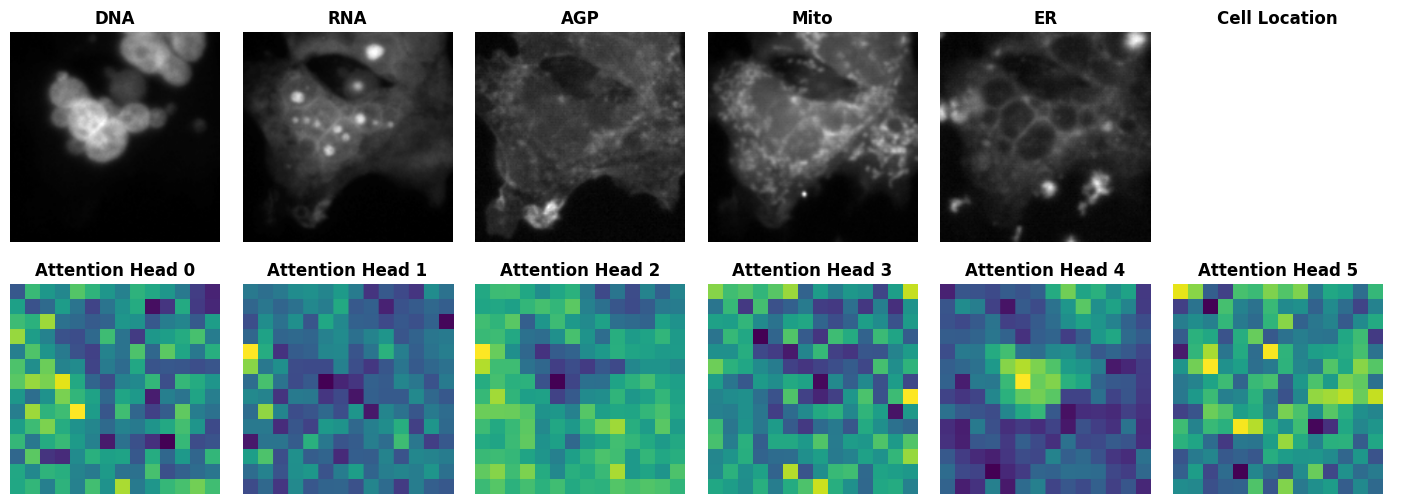

PB000052/L22_s7_object95.tiff
Saved grid to /home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/output/attention_maps/PB000052/L22_s7_object95.tiff/attention_grid.png


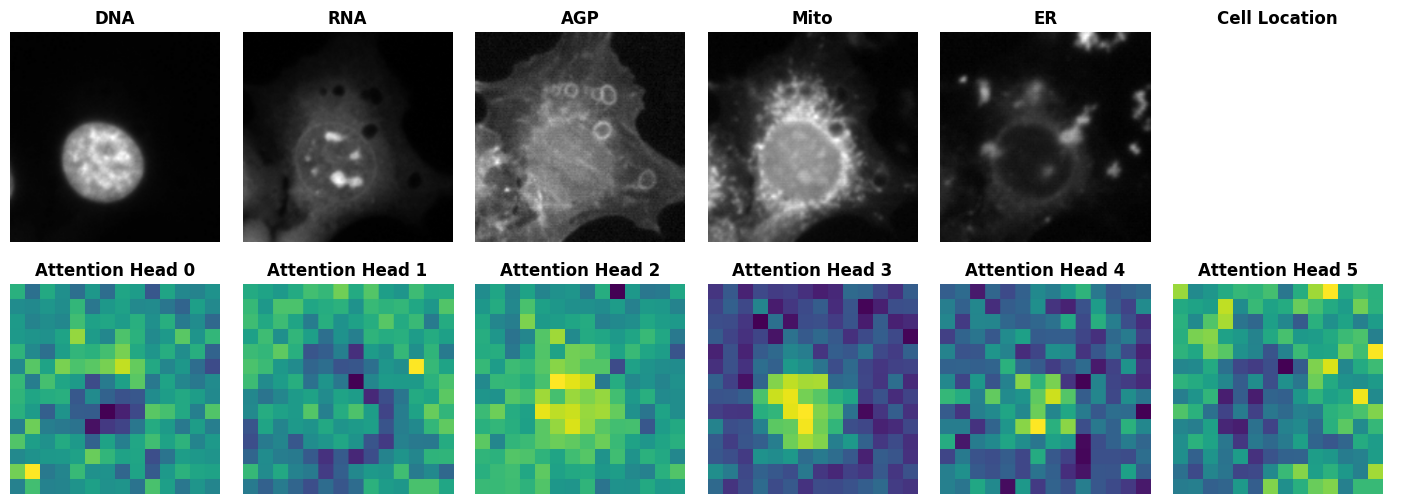

In [100]:
for path in list(joined_df["Image_Name"]):
    print(path)
    dire = f"{base_dir}{path}"
    cell_id = extract_cell_id(path)
    create_image_grid(dire, cell_id)